In [111]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
from subprocess import getoutput
import requests
import sys
import ssl
import pandas as pd
from OpenSSL import crypto
import matplotlib.pyplot as plt
import pandas as pd
import os
from Crypto.PublicKey import RSA
from batch_gdc import *
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from jupyterthemes import jtplot # moje żeby mieć ciemne wykresy :#
jtplot.style()

In [7]:
filename = 'entropy.txt'
data = open(filename).read().splitlines()


In [8]:
data = np.array(data).astype(np.int32)
x = np.arange(len(data))/2
print(data)

[3811 3811 3812 ... 3254 3260 3266]


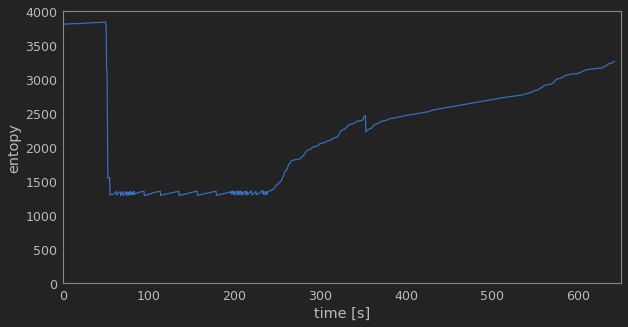

In [9]:
plt.figure(figsize=(10,5))
plt.plot(x,data)
plt.xlabel('time [s]')
plt.ylabel("entopy")
#plt.title('Wykres entropii w czasie przy generacji klucza GPG \n na sytemie Linux Mint 18')
plt.xlim(0,650)
plt.ylim(0,4000)
plt.grid()
plt.savefig('entriopia_NT.png')
plt.show()


# Scrapping data from webistes

## pobranie kluczy + czyszczenie dataframea

In [10]:
keys_paths = os.listdir('keys')
keys_paths = ['keys/'+p for p in keys_paths]

FileNotFoundError: [Errno 2] No such file or directory: 'keys'

In [11]:
pd_keys = [pd.read_csv(p, index_col = 0) for p in keys_paths]
pd_key = pd_keys[0]
for p in pd_keys[1:]:
    pd_key = pd_key.append(p)

NameError: name 'keys_paths' is not defined

In [23]:
del pd_key['Rank']

In [24]:
pd_key = pd_key.reset_index()

In [25]:
del pd_key['index']

In [26]:
pd_key.loc[pd_key['Key'].notnull()]

,Domain,OpenRank,Key
0,mattpresti.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
1,mattsteady.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
2,maximalsound.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
3,mayapuri.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
4,mcphillipstoyota.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
...,...,...,...
233992,mysocialpoker.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233993,naomifindlay.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233995,natinstablog.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233997,natpemarket.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [27]:
pd_key.to_csv('domeny_klucze.csv')

## Dict = klucz : lista domen

In [28]:
key_page = {}

In [29]:
for i, p in pd_key.iterrows():
    key_decode = p['Key']
    hostname = p['Domain']
    if key_decode in key_page:
        key_page[key_decode] = key_page[key_decode] + [hostname]
    else:
        key_page[key_decode] = [hostname,]

In [30]:
del key_page[np.nan]

## Lista - klucz, liczba domen

In [31]:
list_keys = []

In [32]:
for i, k in key_page.items():
    list_keys.append([i, len(k)])

In [33]:
pd_no_keys = pd.DataFrame.from_records(list_keys)

In [34]:
keys_list = pd_no_keys.loc[:,1].values.tolist()

In [35]:
keys_list.sort()
keys_list = np.array(keys_list)

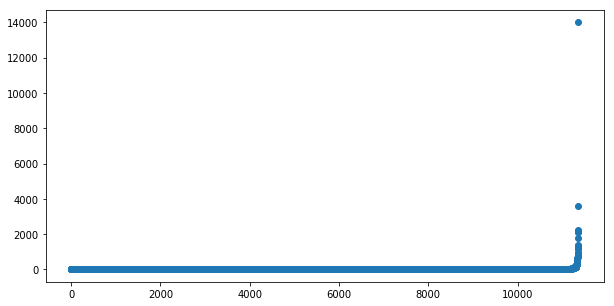

In [36]:
plt.figure(figsize=(10,5))
plt.plot(keys_list[keys_list>1], 'o')

### Ratio

In [37]:
print('domens:', np.sum(keys_list))
print('share key:', np.sum(keys_list[keys_list > 1]))
print('ratio:', np.sum(keys_list[keys_list > 1])/np.sum(keys_list))

domens: 167421
share key: 104600
ratio: 0.624772280657743


In [38]:
pd_no_keys.loc[pd_no_keys.loc[:,1] > 2,:].sort_values(by=[1],ascending=False)

,0,1
304,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,13997
26,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3608
7,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2255
22,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2155
27,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...,2129
...,...,...
17325,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
17324,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
17292,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
3657,b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG...,3


### Key to number
#### wybierz klucz z ramki danych

In [39]:
key_str = pd_no_keys.loc[pd_no_keys.loc[:,1] > 1,:].sort_values(by=[1],ascending=False).iloc[0,0]

#### oczyść z \\\n oraz początku i końca

In [48]:
key_clean = key_str[30:-29].replace('\\n', '')
key_clean

'MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzWJP5cMThJgMBeTvRKKl7N6ZcZAbKDVAtNBNnRhIgSitXxCzKtt9rp2RHkLn76oZjdNO25EPp+QgMiWU/rkkB00Y18Oahw5fi8s+K9dRv6i+gSOiv2jlIeW/S0hOswUUDH0JXFkEPKILzpl5ML7wdp5kt93vHxa7HswOtAxEz2WtxMdezm/3CgO3sls20wl3W03iI+kCt7HyvhGy2aRPLhJfeABpQr0Uku3q6mtomy2cgFawekN/X/aH8KknX799MPcuWutM2q88mtUEBsuZmy2nsjK9J7/yhhCRDzOV/yY8c5+l/u/rWuwwkZ2lgzGp4xBBfhXdr6+m9kmwWCUm9QIDAQAB'

#### zamień na liczbę

In [49]:
key_int = int.from_bytes(key_clean.encode(), 'little')
key_int

27736142053001972894141168940794628257122595916689500327337814341233702579571191726171192003997939169360692208972473464481406697865724011100281443278195278731581691888597354870140246748527444181992252960189151142429554895594863583933923480159126397675192644829119313833703381348968107358436189284486758101278432697304788189716200964589051457558010627706789891951021560856034917805031622495121390702751622947874597999855708672897851711176185905178728389036613779517873556148898466029667317655253909482911745643898582334852578745527682659988105625551105956650520112190774383411319292036989510245130812474077825149865366508826306186444989755628705474943049498460670576842747728621377488734773120353865848580006325434517215958345375320127948921509092572086071871468998600692328490902561812395023297361667096083466166049262940079979675425955889450823899265465043743768226651703902405844287893956335783700461288503339388260968956568468069414657935693

In [10]:
def is_prime(n):
    """
    Assumes that n is a positive natural number
    """
    # We know 1 is not a prime number
    if n == 1:
        return False

    i = 2
    # This will loop from 2 to int(sqrt(x))
    while i*i <= n:
        # Check if i divides x without leaving a remainder
        if n % i == 0:
            # This means that n has a factor in between 2 and sqrt(n)
            # So it is not a prime number
            print(i)
            return False
        i += 1
    # If we did not find any factor in the above loop,
    # then n is a prime number
    return True

In [11]:
is_prime(key_int)

NameError: name 'key_int' is not defined

In [21]:
k = '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAubanqNe6xSQfWiszYK6E\nq/7AgBk8lWhyol87YWFU/sQU56lRRcBuUE6wzhNw8ZlyqbaTB+Lui0/JQ9qE0yIM\ngO9ll8Vy+5YgCDEHGevMQJF/TUAUM1yv1SWlTz0DO2+Yu0t8sjL9wDleqUbJ99PF\nChDxosgx+2STU4LC6o238znnTmw2OKz7UU1z1BpImaYw7jJLt89kU0LyNf2yWKNh\n7iHPD7adPjpaz0Cnc4JzLzESwlWYMPwVevFAwyYaT7CEm+RAjyQH/2gTC/cjD8od\nEliNHXDbRVMnFtgDvDccp4v5wKxG4fo+7WqFkEKjYrreUDw8M9SiRf00VTaqpXEH\n3wIDAQAB\n-----END PUBLIC KEY-----'
#k[30:-29]
k_int = int.from_bytes(k[27:-25].encode(),'little')

In [22]:
is_prime(k_int)

5


False

In [24]:
pub_key = RSA.importKey(k)

In [26]:
print('N',pub_key.n)
print('E',pub_key.e)

N 23444156916788217072968948797613723278925042381586582221140693672863149672676005620893979925204494030744622095025905422202071522522127578033612221016275813745156551118151270658253026197529489724236950117170556081137622165601495755640204329543647366736864367886398715741997966193998377964536823291966611064944123521230452486637382460409243307967480693978253936290404185984017525643259622532424222237847334527637929682299248260640852007183565826447648165000289210266187323013336594237477719650639394912377218794510735697325898093989060223722951869207292817471564468215796618201620610540272670321646987987450753140721631
E 65537


# BatchGCD

In [112]:
pd_key = pd.read_csv('domeny_klucze.csv')

In [113]:
pd_key = pd_key.loc[pd_key['Key'].notnull()]
pd_key.head()

,Unnamed: 0,Domain,OpenRank,Key
0,0,mattpresti.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
1,1,mattsteady.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
2,2,maximalsound.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
3,3,mayapuri.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
4,4,mcphillipstoyota.com,5.56,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [114]:
k = pd_key['Key'][0][2:-1].replace('\\n','\n')
RSA_k = RSA.importKey(k)
print('N',RSA_k.n)

N 17059146141012133763773634463292123091469778926487960168838674273580875568930554499535452778280309510381388821366672451262111919691707301770660275123550489663156686537239462756622063400691346629965632643306140057618758717355160147711430156902734133554005818089521047252983079697522965432068428017061277314645004253227621537850144033515027800615070179907495604008896981663698482662998511938647557439978144458596054645877010774004330755647198687022745318985355048856019928344685688288213742095851956478232174087201389092182050546459620737952594042786301806650575023999541964079190013656520057962677278515815374497078181


In [115]:
N = []
for ii, p in tqdm(pd_key.iterrows(), total=pd_key.shape[0]):
    try:
        key = p['Key'][2:-1].replace('\\n','\n')
        RSA_key = RSA.importKey(key)
        N.append(RSA_key.n)
    except:
        N.append(np.nan)

100%|██████████| 167421/167421 [00:59<00:00, 2827.03it/s]


In [121]:
batchgcd_faster(N[-100:])

OverflowError: int too large to convert to float